In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/project/spurious_concepts/ConceptBottleneck/')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from copy import copy 
import itertools
import json
import argparse 

In [4]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [137]:
is_jupyter = 'ipykernel' in sys.modules
if is_jupyter:
    num_objects = 4
    encoder_model='small7'
    seed = 42
    epochs = 30
    expand_dim_encoder = 0
    num_middle_encoder = 0
else:
    parser = argparse.ArgumentParser(description="Synthetic Dataset Experiments")


    parser.add_argument('--num_objects', type=int, default=2, help='Number of objects')
    parser.add_argument('--encoder_model', type=str, default='inceptionv3', help='Encoder model')
    parser.add_argument('--seed', type=int, default=42, help='Random seed')
    parser.add_argument('--epochs', type=int, default=50, help='Number of epochs')
    parser.add_argument('--expand_dim_encoder', type=int, default=0, help='For MLPs, size of the middle layer')
    parser.add_argument('--num_middle_encoder', type=int, default=0, help='For MLPs, number of middle layers')

    args = parser.parse_args()
    num_objects = args.num_objects
    encoder_model = args.encoder_model 
    seed = args.seed 
    epochs = args.epochs 

parameters = {
    'seed': seed, 
    'encoder_model': encoder_model ,
    'epochs': epochs, 
    'num_attributes': num_objects*2,
    'expand_dim_encoder': expand_dim_encoder, 
    'num_middle_encoder': num_middle_encoder, 
}


In [138]:
np.random.seed(seed)
torch.manual_seed(seed)

In [139]:
train_loader, val_loader, test_loader, train_pkl, val_pkl, test_pkl = get_data(num_objects,encoder_model=encoder_model)

In [140]:
test_images, test_y, test_c = unroll_data(test_loader)

In [141]:
dataset_name = "synthetic_object/synthetic_{}".format(num_objects)

In [143]:
log_folder = get_log_folder(dataset_name,parameters).split("/")[-1]
results_folder = "../../results/synthetic/{}".format(log_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [105]:
joint_model = get_synthetic_model(dataset_name,parameters)

In [106]:
joint_model = joint_model.to(device)

## Plot the Dataset

In [107]:
dataset_directory = "../../../../datasets"

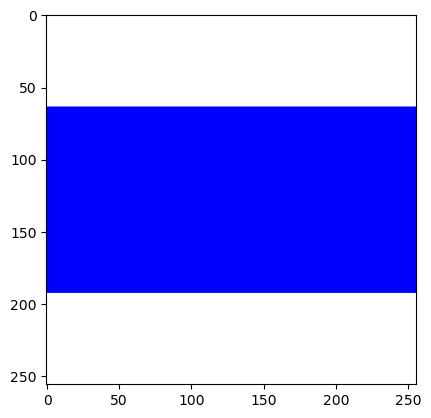

In [108]:
img_path = dataset_directory+'/'+train_pkl[0]['img_path']
image = Image.open(img_path)
plt.imshow(image)

## Analyze Accuracy

In [109]:
train_acc =  get_accuracy(joint_model,run_joint_model,train_loader).item()
val_acc = get_accuracy(joint_model,run_joint_model,val_loader).item()
test_acc =get_accuracy(joint_model,run_joint_model,val_loader).item()

In [110]:
accuracy_by_concept_train = get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True).detach().numpy()

## Analyze Concept-Input Relationships

### Maximal Activation

In [111]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

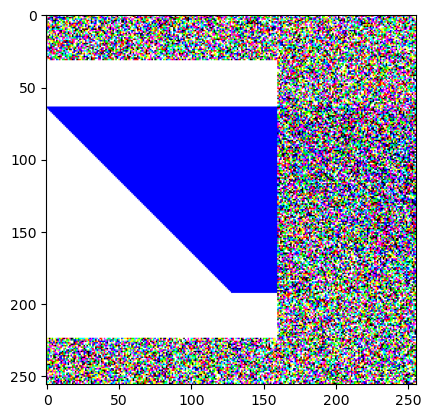

In [112]:
activation_values = []

for concept_num in range(num_objects*2):
    val_for_concept = 0
    trials = 5

    for _ in range(trials):
        data_point = random.randint(0,len(test_images)-1)
        input_image = deepcopy(test_images[data_point:data_point+1])
        current_concept_val = test_c[data_point][concept_num]

        ret_image = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                        get_valid_image_function(concept_num,num_objects,epsilon=32),fixed_image=input_image,current_concept_val=current_concept_val).to(device)
        predicted_concept = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1].detach().cpu())[concept_num][0].detach().numpy()
        
        val_for_concept += abs(predicted_concept-current_concept_val.detach().numpy())/trials 
        ret_image = ret_image.detach()[0].cpu().numpy()
        im = numpy_to_pil(ret_image) 
        plt.imshow(im)
        im.save("{}/{}.png".format(results_folder,"adversarial_{}".format(concept_num)))
    activation_values.append(val_for_concept)


In [113]:
joint_model = joint_model.cpu()
torch.cuda.empty_cache()

In [114]:
activation_values 

[1.0, 1.0]

In [115]:
final_data = {
    'train_accuracy': train_acc, 
    'val_accuracy': val_acc, 
    'test_accuracy': test_acc, 
    'concept_accuracy': accuracy_by_concept_train.tolist(), 
    'adversarial_activations': np.array(activation_values).tolist(),  
    'parameters': parameters, 
    'run_name': log_folder, 
}

In [116]:
final_data 

{'train_accuracy': 1.0,
 'val_accuracy': 1.0,
 'test_accuracy': 1.0,
 'concept_accuracy': [1.0, 1.0],
 'adversarial_activations': [1.0, 1.0],
 'parameters': {'seed': 42,
  'encoder_model': 'mlp',
  'epochs': 50,
  'num_attributes': 2,
  'expand_dim_encoder': 5,
  'num_middle_encoder': 1},
 'run_name': 'f23ff792'}

In [117]:
json.dump(final_data,open("{}/results.json".format(results_folder),"w"))